In [1]:
import pandas as pd

In [52]:
from collections import Counter

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import BytesIO
import base64
from IPython.display import display, Markdown, HTML

def analyze_dataframe(df, columns=None, display_output=True, figure_size=(6, 4), name = 'DataFrame'):
    """
    Analyzes a pandas DataFrame and generates a minimalistic report with smaller figures.
    
    For categorical columns:
    - Gives counters for each category
    - Creates a compact pie chart
    
    For numerical columns:
    - Shows distribution histogram and box plot
    - Provides concise summary statistics
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze
    columns (list, optional): List of column names to analyze. If None, all columns are analyzed.
    display_output (bool, optional): If True, displays the output directly in the notebook.
                                    If False, returns the markdown string.
    figure_size (tuple, optional): Width and height of figures in inches. Default is (6, 4).
    
    Returns:
    If display_output is True: None (output is displayed directly)
    If display_output is False: str (markdown-formatted report)
    """
    # Set a clean, minimalist style
    plt.style.use('ggplot')
    
    # Select columns to analyze
    if columns is None:
        columns = df.columns
    else:
        # Make sure all specified columns exist in the dataframe
        for col in columns:
            if col not in df.columns:
                raise ValueError(f"Column '{col}' not found in the DataFrame")
        
    # Create a buffer to hold the output
    report = []
    report.append("# "+ name + " Analysis Report\n")
    
    # Brief DataFrame information
    report.append(f"**Rows:** {df.shape[0]} | **Analyzed columns:** {len(columns)} of {df.shape[1]} | **Missing values:** {df[columns].isna().sum().sum()}\n")
    
    # Analyze each selected column
    for col in columns:
        report.append(f"## {col} ({df[col].dtype})\n")
        missing = df[col].isna().sum()
        if missing > 0:
            report.append(f"*Missing: {missing} ({missing/len(df):.1%})*\n")
        
        # Check if column is categorical or can be treated as categorical
        if df[col].dtype == 'object' or df[col].dtype.name == 'category' or (df[col].dtype in ['int64', 'float64'] and df[col].nunique() < 20):
            # For categorical data
            if df[col].dropna().empty:
                report.append("*All values missing*\n")
                continue
                
            value_counts = df[col].value_counts()
            
            # Create a compact table of value counts
            report.append("| Value | Count | % |")
            report.append("|-------|------:|---:|")
            
            # Show only top categories for readability
            top_n = 7
            if len(value_counts) > top_n:
                top_values = value_counts.head(top_n)
                for value, count in top_values.items():
                    report.append(f"| {value} | {count} | {count/len(df):.1%} |")
                report.append(f"| *Others* | {value_counts[top_n:].sum()} | {value_counts[top_n:].sum()/len(df):.1%} |")
            else:
                for value, count in value_counts.items():
                    report.append(f"| {value} | {count} | {count/len(df):.1%} |")
            
            # Create smaller pie chart (limit to top categories for clarity)
            plt.figure(figsize=figure_size)
            
            if len(value_counts) > 5:
                # For many categories, group smaller ones as "Others"
                top_5 = value_counts.head(4)
                others = pd.Series({'Others': value_counts[4:].sum()})
                plot_data = pd.concat([top_5, others])
                
                plt.pie(plot_data, labels=plot_data.index, autopct='%1.0f%%', textprops={'fontsize': 9})
                plt.title(f'Distribution of {col}', fontsize=10)
            else:
                plt.pie(value_counts, labels=value_counts.index, autopct='%1.0f%%', textprops={'fontsize': 9})
                plt.title(f'Distribution of {col}', fontsize=10)
                
            plt.axis('equal')
            
            # Save figure to buffer with smaller size
            fig_buffer = BytesIO()
            plt.savefig(fig_buffer, format="png", dpi=80, bbox_inches='tight')
            fig_buffer.seek(0)
            fig_data = base64.b64encode(fig_buffer.read()).decode()
            
            # Append figure to report
            report.append(f"\n![{col}](data:image/png;base64,{fig_data})")
            plt.close()
            
        elif df[col].dtype in ['int64', 'float64']:
            # For numerical data
            if df[col].dropna().empty:
                report.append("*All values missing*\n")
                continue
                
            # Concise summary statistics
            stats = df[col].describe()
            
            # Create a compact table of stats
            report.append("| Stat | Value |")
            report.append("|------|------:|")
            report.append(f"| Min | {stats['min']:.2f} |")
            report.append(f"| Mean | {stats['mean']:.2f} |")
            report.append(f"| Median | {stats['50%']:.2f} |")
            report.append(f"| Max | {stats['max']:.2f} |")
            report.append(f"| Std | {stats['std']:.2f} |")
            
            # Create a combined figure with histogram and boxplot
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figure_size, 
                                          gridspec_kw={'height_ratios': [3, 1]})
            
            # Histogram on top
            sns.histplot(df[col].dropna(), kde=True, ax=ax1, color='steelblue', alpha=0.7)
            ax1.set_title(f'Distribution of {col}', fontsize=10)
            ax1.tick_params(labelsize=8)
            ax1.set_xlabel('')
            ax1.set_ylabel('Frequency', fontsize=8)
            
            # Add vertical lines for key stats
            ax1.axvline(stats['mean'], color='red', linestyle='-', alpha=0.7, linewidth=1)
            ax1.axvline(stats['50%'], color='green', linestyle='--', alpha=0.7, linewidth=1)
            
            # Box plot below
            sns.boxplot(x=df[col].dropna(), ax=ax2, color='lightsteelblue')
            ax2.set_xlabel(col, fontsize=8)
            ax2.tick_params(labelsize=8)
            
            plt.tight_layout()
            
            # Save figure to buffer with smaller size
            fig_buffer = BytesIO()
            plt.savefig(fig_buffer, format="png", dpi=80, bbox_inches='tight')
            fig_buffer.seek(0)
            fig_data = base64.b64encode(fig_buffer.read()).decode()
            
            # Append figure to report
            report.append(f"\n![{col}](data:image/png;base64,{fig_data})")
            plt.close()
        
        else:
            # For other data types
            report.append(f"*Unique values:* {df[col].nunique()}\n")
            report.append(f"*Sample values:* {', '.join(str(x) for x in df[col].dropna().head(3).tolist())}\n")
        
        report.append("\n---\n")
    
    # Combine all parts of the report
    markdown_report = "\n".join(report)
    
    # Either display the report in the notebook or return it
    if display_output:
        display(Markdown(markdown_report))
        return None
    else:
        return markdown_report

# 1 metadata

In [127]:
data_1 = pd.read_csv('1-metadata.csv')

In [128]:
data_1.head(1)

,Run,BioProject,Age,Sex,BMI,Country,Continent,Ethnicity,Study.Group,City,Treatment
0,SRR6166632,PRJNA397112,58,M,19.2,India,Asia,Indian,Healthy,Bhopal,Non_veg


In [131]:
data_1.columns

Index(['Run', 'BioProject', 'Age', 'Sex', 'BMI', 'Country', 'Continent',
       'Ethnicity', 'Study.Group', 'City', 'Treatment'],
      dtype='object')

# Metadata 1 Analysis Report

**Rows:** 88 | **Analyzed columns:** 10 of 11 | **Missing values:** 0

## BioProject (object)

| Value | Count | % |
|-------|------:|---:|
| PRJNA397112 | 88 | 100.0% |

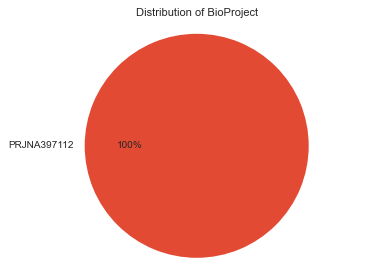

---

## Age (int64)

| Stat | Value |
|------|------:|
| Min | 19.00 |
| Mean | 35.32 |
| Median | 28.00 |
| Max | 71.00 |
| Std | 14.68 |

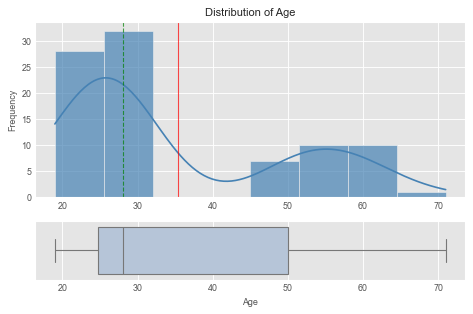

---

## Sex (object)

| Value | Count | % |
|-------|------:|---:|
| F | 46 | 52.3% |
| M | 41 | 46.6% |
|  M | 1 | 1.1% |

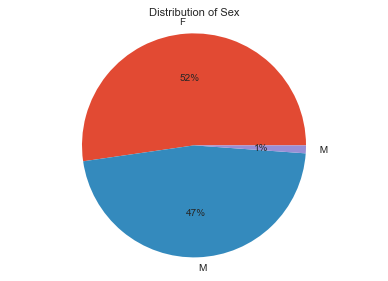

---

## BMI (float64)

| Stat | Value |
|------|------:|
| Min | 16.04 |
| Mean | 23.06 |
| Median | 22.62 |
| Max | 36.40 |
| Std | 3.57 |

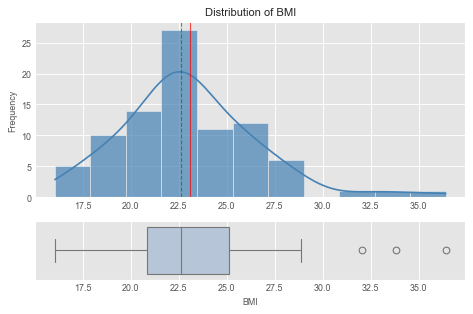

---

## Country (object)

| Value | Count | % |
|-------|------:|---:|
| India | 88 | 100.0% |

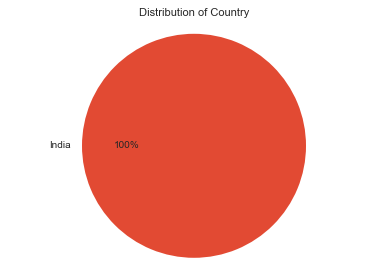

---

## Continent (object)

| Value | Count | % |
|-------|------:|---:|
| Asia | 88 | 100.0% |

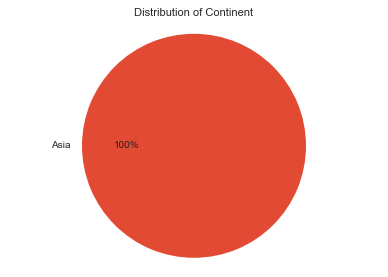

---

## Ethnicity (object)

| Value | Count | % |
|-------|------:|---:|
| Indian | 88 | 100.0% |

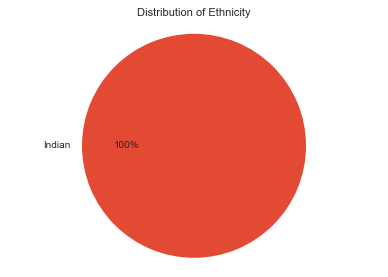

---

## Study.Group (object)

| Value | Count | % |
|-------|------:|---:|
| Healthy | 88 | 100.0% |

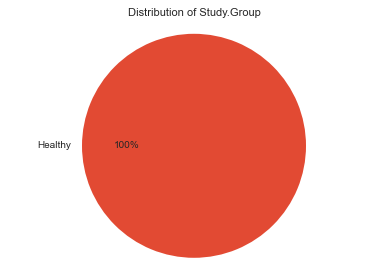

---

## City (object)

| Value | Count | % |
|-------|------:|---:|
| Bhopal | 49 | 55.7% |
| Kasaragod | 39 | 44.3% |

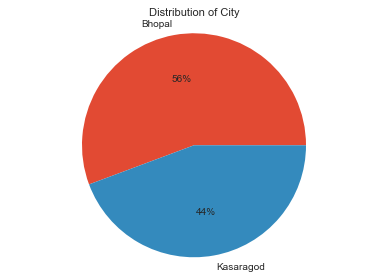

---

## Treatment (object)

| Value | Count | % |
|-------|------:|---:|
| Non_veg | 57 | 64.8% |
| Veg | 31 | 35.2% |

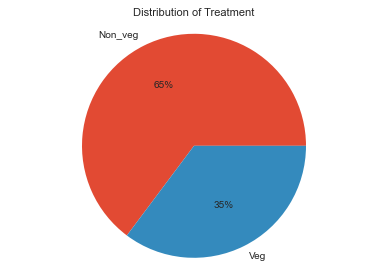

---


In [139]:
analyze_dataframe(data_1, columns = ['BioProject', 'Age', 'Sex', 'BMI', 'Country', 'Continent',
       'Ethnicity', 'Study.Group', 'City', 'Treatment'],  name = "Metadata 1", display_output=True)

In [54]:
Counter(data_1.BioProject)

Counter({'PRJNA397112': 88})

# 9 Metadata

In [28]:
data_9 = pd.read_csv('9-metadata.csv')

In [30]:
data_9.head()

,Run,BioProject,Age,Sex,BMI,Country,Continent,Ethnicity,Study.Group,Unnamed: 9,City
0,SRR18588257,PRJNA812699,48,F,22.010078,USA,North America,Hispanic,Irritable bowel syndrome,NaN,Los Angeles
1,SRR18588258,PRJNA812699,19,F,19.648481,USA,North America,Hispanic,Irritable bowel syndrome,NaN,Los Angeles
2,SRR18588261,PRJNA812699,34,F,22.000000,USA,North America,Hispanic,Irritable bowel syndrome,NaN,Los Angeles
3,SRR18588264,PRJNA812699,28,F,25.000000,USA,North America,Multiracial,Irritable bowel syndrome,NaN,Los Angeles
4,SRR18588266,PRJNA812699,21,F,26.602880,USA,North America,Asian,Irritable bowel syndrome,NaN,Los Angeles


# Metadata 9 Analysis Report

**Rows:** 644 | **Analyzed columns:** 9 of 11 | **Missing values:** 1

## BioProject (object)

| Value | Count | % |
|-------|------:|---:|
| PRJNA812699 | 644 | 100.0% |

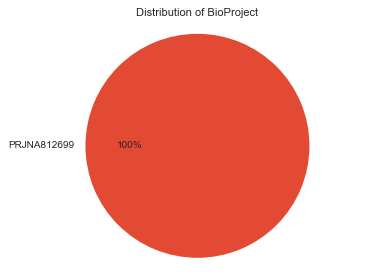

---

## Age (int64)

| Stat | Value |
|------|------:|
| Min | 18.00 |
| Mean | 32.41 |
| Median | 29.50 |
| Max | 70.00 |
| Std | 11.57 |

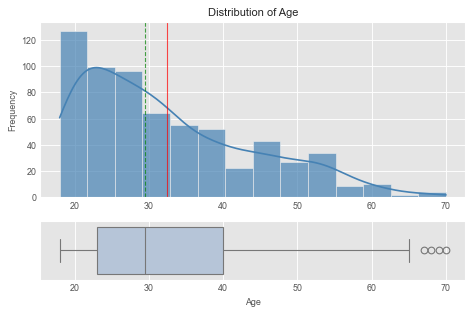

---

## Sex (object)

| Value | Count | % |
|-------|------:|---:|
| F | 472 | 73.3% |
| M | 172 | 26.7% |

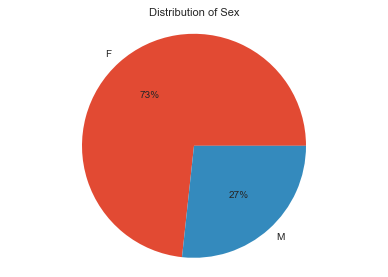

---

## BMI (float64)

*Missing: 1 (0.2%)*

| Stat | Value |
|------|------:|
| Min | 0.00 |
| Mean | 25.79 |
| Median | 25.00 |
| Max | 47.54 |
| Std | 5.53 |

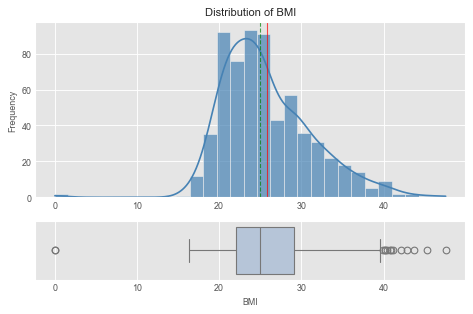

---

## Country (object)

| Value | Count | % |
|-------|------:|---:|
| USA | 644 | 100.0% |

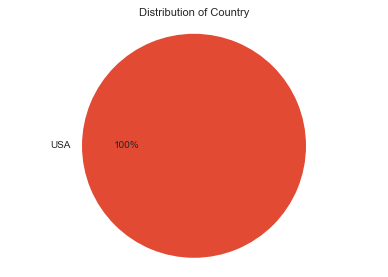

---

## Continent (object)

| Value | Count | % |
|-------|------:|---:|
| North America | 644 | 100.0% |

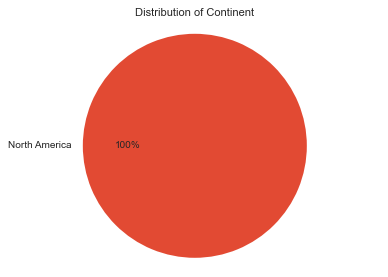

---

## Ethnicity (object)

| Value | Count | % |
|-------|------:|---:|
| Non_Hispanic_White | 277 | 43.0% |
| Hispanic | 148 | 23.0% |
| Asian | 101 | 15.7% |
| Black | 63 | 9.8% |
| Multiracial | 53 | 8.2% |
| Native_American | 2 | 0.3% |

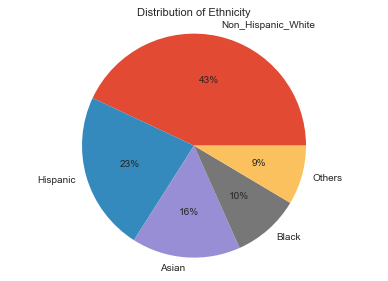

---

## Study.Group (object)

| Value | Count | % |
|-------|------:|---:|
| Irritable bowel syndrome | 413 | 64.1% |
| Healthy | 231 | 35.9% |

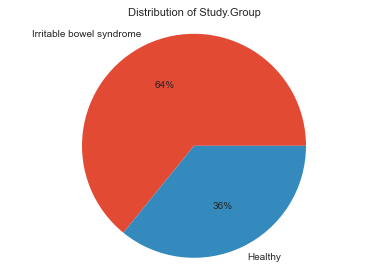

---

## City (object)

| Value | Count | % |
|-------|------:|---:|
| Los Angeles | 594 | 92.2% |
| Buffalo | 50 | 7.8% |

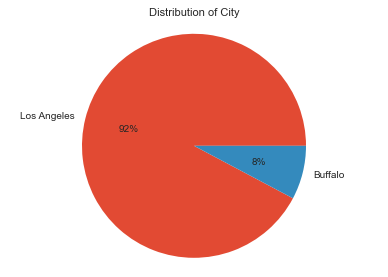

---


In [141]:
analyze_dataframe(data_9, columns = ['BioProject', 'Age', 'Sex', 'BMI', 'Country', 'Continent',
       'Ethnicity', 'Study.Group', 'City'],  name = "Metadata 9", display_output=True)

# 15 Metadata

In [143]:
data_15 = pd.read_csv('15-metadata.csv')

In [145]:
data_15.head(1)

,Run,BioProject,Age,Sex,BMI,Country,Continent,Ethnicity,Study.Group,City
0,SRR2143516,PRJNA290926,64.0,M,36.227509,USA,North America,White,Healthy,Ann Arbor


# metadata 15 Analysis Report

**Rows:** 544 | **Analyzed columns:** 9 of 10 | **Missing values:** 26

## BioProject (object)

| Value | Count | % |
|-------|------:|---:|
| PRJNA290926 | 544 | 100.0% |

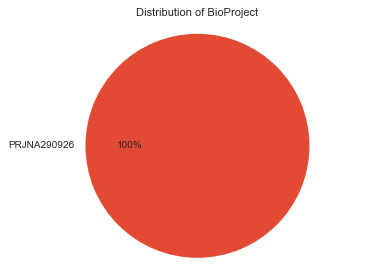

---

## Age (float64)

*Missing: 5 (0.9%)*

| Stat | Value |
|------|------:|
| Min | 29.00 |
| Mean | 60.32 |
| Median | 60.00 |
| Max | 89.00 |
| Std | 12.16 |

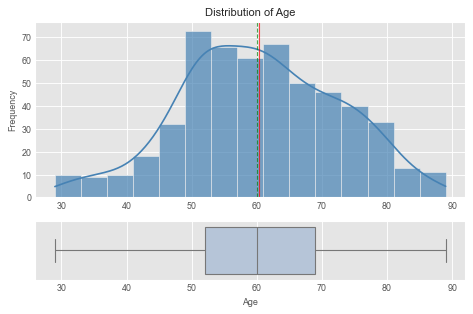

---

## Sex (object)

*Missing: 5 (0.9%)*

| Value | Count | % |
|-------|------:|---:|
| M | 271 | 49.8% |
| F | 268 | 49.3% |

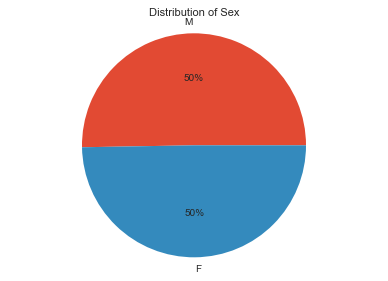

---

## BMI (float64)

*Missing: 6 (1.1%)*

| Stat | Value |
|------|------:|
| Min | 0.00 |
| Mean | 27.18 |
| Median | 26.51 |
| Max | 57.46 |
| Std | 5.63 |

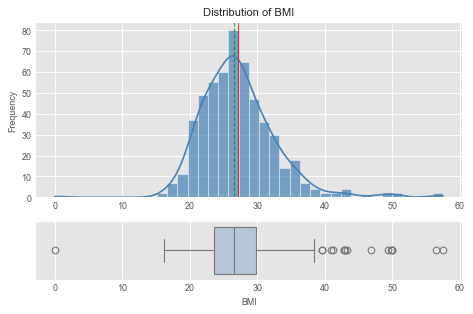

---

## Country (object)

*Missing: 5 (0.9%)*

| Value | Count | % |
|-------|------:|---:|
| USA | 352 | 64.7% |
| Canada | 187 | 34.4% |

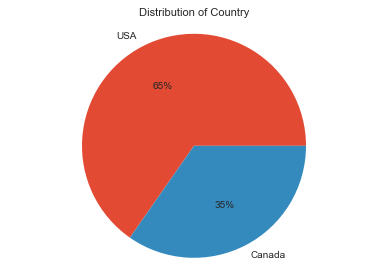

---

## Continent (object)

| Value | Count | % |
|-------|------:|---:|
| North America | 542 | 99.6% |
| uncalculated | 2 | 0.4% |

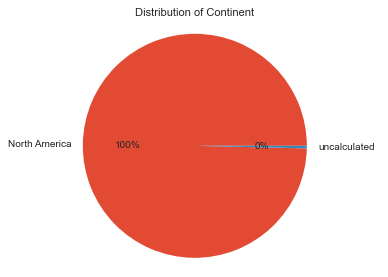

---

## Ethnicity (object)

| Value | Count | % |
|-------|------:|---:|
| White | 487 | 89.5% |
| Asian | 22 | 4.0% |
| Black | 21 | 3.9% |
| Other | 6 | 1.1% |
| mock | 5 | 0.9% |
| error | 2 | 0.4% |
| Native | 1 | 0.2% |

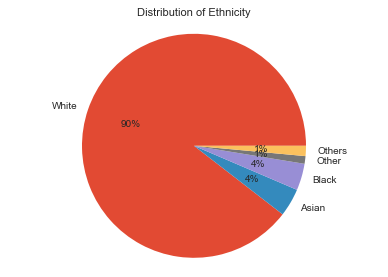

---

## Study.Group (object)

| Value | Count | % |
|-------|------:|---:|
| adenoma | 225 | 41.4% |
| Healthy | 187 | 34.4% |
| cancer | 127 | 23.3% |
| mock | 5 | 0.9% |

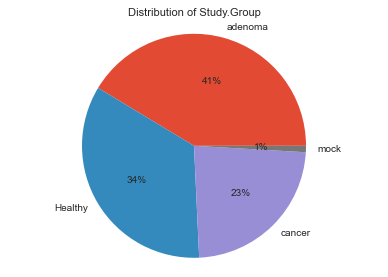

---

## City (object)

*Missing: 5 (0.9%)*

| Value | Count | % |
|-------|------:|---:|
| Toronto | 187 | 34.4% |
| Boston | 133 | 24.4% |
| Ann Arbor | 113 | 20.8% |
| Houston | 106 | 19.5% |

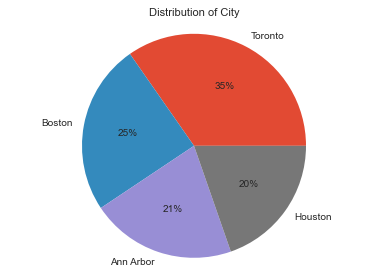

---


In [151]:
analyze_dataframe(data_15, columns = ['BioProject', 'Age', 'Sex', 'BMI', 'Country', 'Continent',
       'Ethnicity', 'Study.Group', 'City'], name = "metadata 15")

# Metadata_all

In [153]:
data_all = pd.read_csv('metadata_all.csv')

In [158]:
data_all.head().columns

Index(['Run', 'BioProject', 'Age', 'Sex', 'BMI', 'Country', 'Continent',
       'Ethnicity', 'Study.Group', 'author'],
      dtype='object')

# Metadata all Analysis Report

**Rows:** 1620 | **Analyzed columns:** 8 of 10 | **Missing values:** 346

## BioProject (object)

| Value | Count | % |
|-------|------:|---:|
| PRJNA290926 | 544 | 33.6% |
| PRJNA812699 | 352 | 21.7% |
| PRJNA534511 | 184 | 11.4% |
| PRJNA389481 | 96 | 5.9% |
| PRJNA397112 | 88 | 5.4% |
| PRJNA986915 | 66 | 4.1% |
| PRJNA753264 | 52 | 3.2% |
| *Others* | 238 | 14.7% |

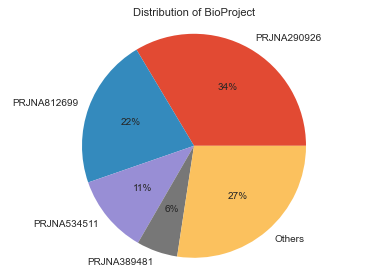

---

## Age (float64)

*Missing: 41 (2.5%)*

| Stat | Value |
|------|------:|
| Min | 0.50 |
| Mean | 50.96 |
| Median | 55.00 |
| Max | 89.00 |
| Std | 17.27 |

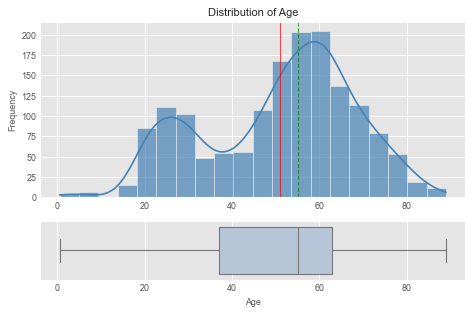

---

## Sex (object)

*Missing: 169 (10.4%)*

| Value | Count | % |
|-------|------:|---:|
| F | 772 | 47.7% |
| M | 678 | 41.9% |
|  M | 1 | 0.1% |

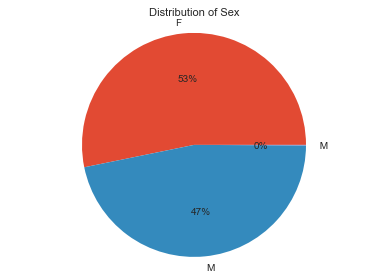

---

## BMI (float64)

*Missing: 60 (3.7%)*

| Stat | Value |
|------|------:|
| Min | 0.00 |
| Mean | 26.83 |
| Median | 25.91 |
| Max | 57.46 |
| Std | 6.11 |

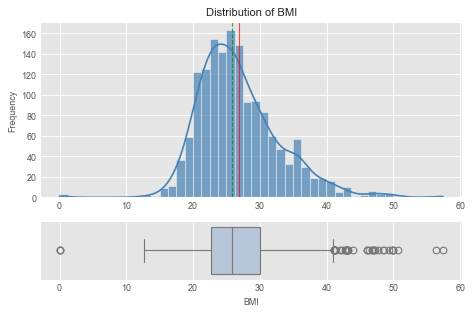

---

## Country (object)

*Missing: 5 (0.3%)*

| Value | Count | % |
|-------|------:|---:|
| USA | 1244 | 76.8% |
| Canada | 187 | 11.5% |
| India | 88 | 5.4% |
| China | 65 | 4.0% |
| Italy | 31 | 1.9% |

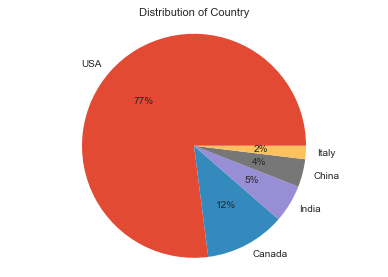

---

## Ethnicity (object)

*Missing: 70 (4.3%)*

| Value | Count | % |
|-------|------:|---:|
| Caucasian | 925 | 57.1% |
| Asian | 250 | 15.4% |
| African American | 245 | 15.1% |
| Hispanic/Latino | 85 | 5.2% |
| Multiracial | 27 | 1.7% |
| Other | 9 | 0.6% |
| mock | 5 | 0.3% |
| *Others* | 4 | 0.2% |

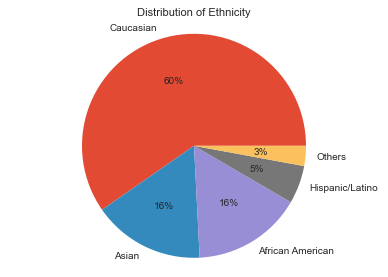

---

## Study.Group (object)

*Missing: 1 (0.1%)*

| Value | Count | % |
|-------|------:|---:|
| Healthy | 602 | 37.2% |
| Irritable bowel syndrome | 276 | 17.0% |
| adenoma | 225 | 13.9% |
| cancer | 127 | 7.8% |
| Polyp | 114 | 7.0% |
| Obese and MCI | 66 | 4.1% |
| T2D | 49 | 3.0% |
| *Others* | 160 | 9.9% |

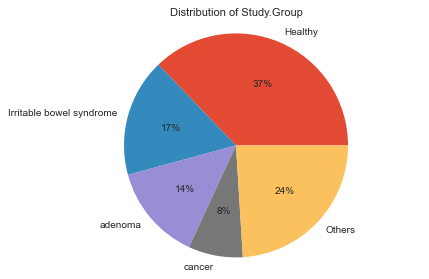

---

## author (object)

| Value | Count | % |
|-------|------:|---:|
| Baxter-2016 | 544 | 33.6% |
| Jacobs-2023 | 352 | 21.7% |
| Dadkhah-2019 | 184 | 11.4% |
| Barengolts-2018 | 96 | 5.9% |
| Dhakan-2019 | 88 | 5.4% |
| McLoed-2023 | 66 | 4.1% |
| Yu-2022 | 52 | 3.2% |
| *Others* | 238 | 14.7% |

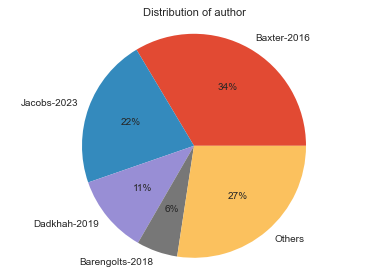

---


In [160]:
analyze_dataframe(data_all, columns = ['BioProject', 'Age', 'Sex', 'BMI', 'Country',
       'Ethnicity', 'Study.Group', 'author'],  name = "Metadata all", display_output=True)

# Metadata_northeastcity

In [40]:
data_ne = pd.read_csv('metadata_northeastcity.csv')

In [42]:
data_ne.head()

,#NAME,BioProject,Age,Sex,BMI,Country,Continent,Ethnicity,Study.Group,author,city,AA_status,Health_status
0,SRR2143519,PRJNA290926,81,F,23.03005,Canada,North America,Caucasian,adenoma,Baxter-2016,Toronto,Non-African American,Diseased
1,SRR2143522,PRJNA290926,51,F,26.17188,USA,North America,Caucasian,Healthy,Baxter-2016,Boston,Non-African American,Healthy
2,SRR2143523,PRJNA290926,78,M,26.36560,USA,North America,Caucasian,cancer,Baxter-2016,Boston,Non-African American,Diseased
3,SRR2143525,PRJNA290926,63,F,22.76944,USA,North America,Caucasian,Healthy,Baxter-2016,Boston,Non-African American,Healthy
4,SRR2143527,PRJNA290926,65,F,21.51386,Canada,North America,Caucasian,Healthy,Baxter-2016,Toronto,Non-African American,Healthy


# Metadata NorthEast Analysis Report

**Rows:** 501 | **Analyzed columns:** 11 of 13 | **Missing values:** 12

## BioProject (object)

| Value | Count | % |
|-------|------:|---:|
| PRJNA290926 | 318 | 63.5% |
| PRJNA534511 | 171 | 34.1% |
| PRJNA222611 | 12 | 2.4% |

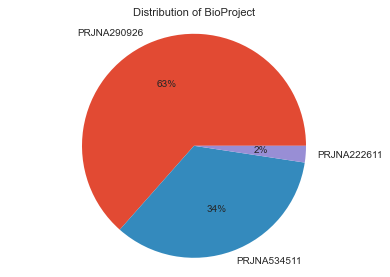

---

## Age (int64)

| Stat | Value |
|------|------:|
| Min | 29.00 |
| Mean | 62.22 |
| Median | 63.00 |
| Max | 89.00 |
| Std | 11.50 |

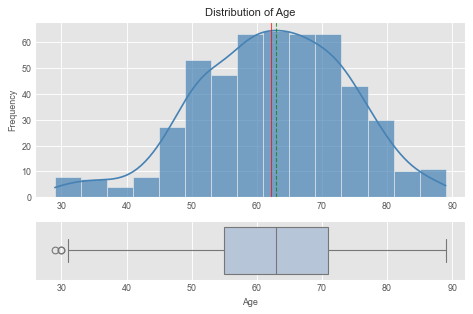

---

## Sex (object)

*Missing: 12 (2.4%)*

| Value | Count | % |
|-------|------:|---:|
| M | 264 | 52.7% |
| F | 225 | 44.9% |

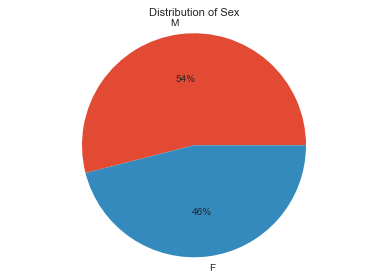

---

## BMI (float64)

| Stat | Value |
|------|------:|
| Min | 16.23 |
| Mean | 27.08 |
| Median | 26.45 |
| Max | 57.46 |
| Std | 5.37 |

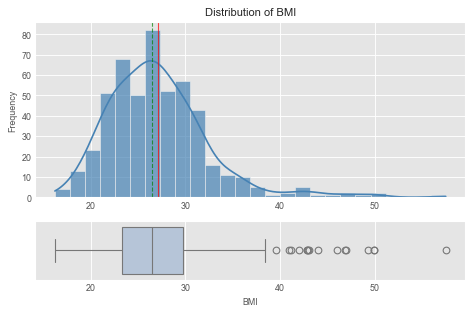

---

## Country (object)

| Value | Count | % |
|-------|------:|---:|
| USA | 314 | 62.7% |
| Canada | 187 | 37.3% |

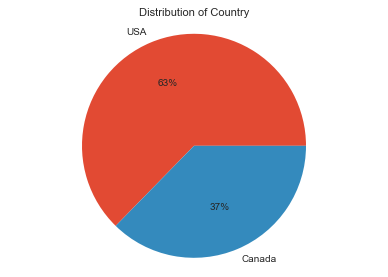

---

## Ethnicity (object)

| Value | Count | % |
|-------|------:|---:|
| Caucasian | 454 | 90.6% |
| African American | 36 | 7.2% |
| Asian | 8 | 1.6% |
| Other | 2 | 0.4% |
| Native American | 1 | 0.2% |

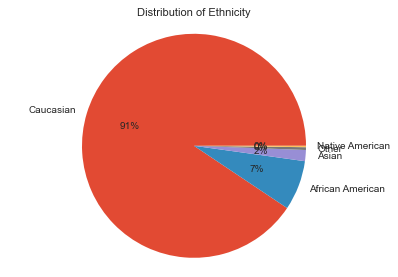

---

## Study.Group (object)

| Value | Count | % |
|-------|------:|---:|
| adenoma | 180 | 35.9% |
| Healthy | 139 | 27.7% |
| Polyp | 107 | 21.4% |
| cancer | 75 | 15.0% |

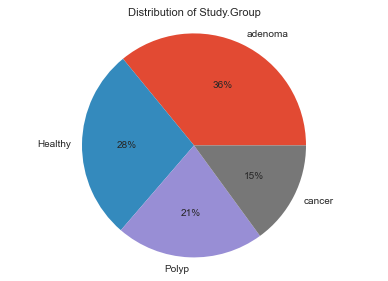

---

## author (object)

| Value | Count | % |
|-------|------:|---:|
| Baxter-2016 | 318 | 63.5% |
| Dadkhah-2019 | 171 | 34.1% |
| Brim-2013 | 12 | 2.4% |

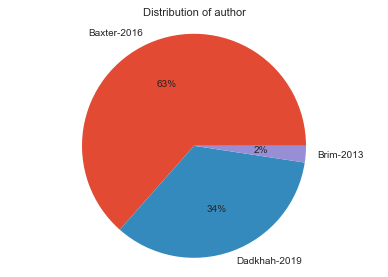

---

## city (object)

| Value | Count | % |
|-------|------:|---:|
| Toronto | 187 | 37.3% |
| DC | 183 | 36.5% |
| Boston | 131 | 26.1% |

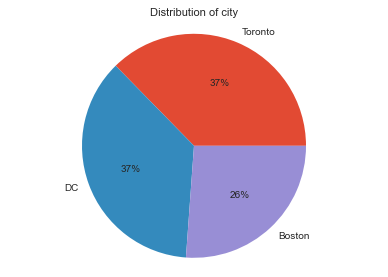

---

## AA_status (object)

| Value | Count | % |
|-------|------:|---:|
| Non-African American | 465 | 92.8% |
| African American | 36 | 7.2% |

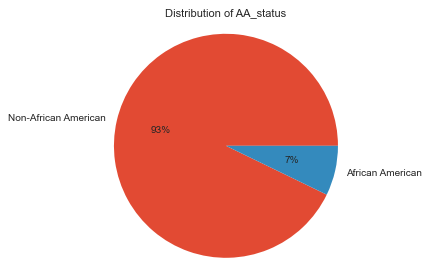

---

## Health_status (object)

| Value | Count | % |
|-------|------:|---:|
| Diseased | 362 | 72.3% |
| Healthy | 139 | 27.7% |

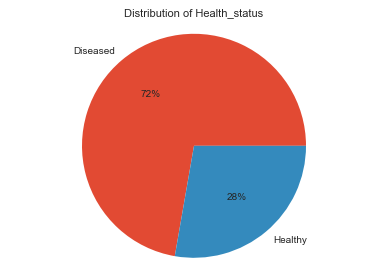

---


In [162]:
analyze_dataframe(data_ne, columns = ['BioProject', 'Age', 'Sex', 'BMI', 'Country',
       'Ethnicity', 'Study.Group', 'author', 'city' ,'AA_status', 'Health_status'],  name = "Metadata NorthEast", display_output=True)

# Taxonomy All

In [44]:
data_tax_all = pd.read_csv('taxanomy_all.csv')

In [46]:
data_tax_all.head()

,Unnamed: 0,Kingdom,Phylum,Class,Order,Family,Genus
0,TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGC...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9
1,TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAGT...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9
2,CTCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAG...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9
3,CTACTCCTACGGGAGGCAGCAGTGGGGAATCTTCCGCAATGGGCGA...,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Veillonellaceae,Dialister
4,CCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGGGAAACCC...,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Faecalibacterium


In [177]:
data_tax_all = data_tax_all.fillna(' ')

In [179]:
data_tax_all_alias = data_tax_all['Kingdom']+'_'+data_tax_all['Phylum']+'_'+data_tax_all['Class']+'_'+data_tax_all['Order']+'_'+data_tax_all['Family']+'_'+data_tax_all['Genus']

In [181]:
data_tax_all['alias'] = data_tax_all_alias

In [182]:
data_tax_all

,Unnamed: 0,Kingdom,Phylum,Class,Order,Family,Genus,alias
0,TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGC...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9,Bacteria_Bacteroidota_Bacteroidia_Bacteroidale...
1,TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAGT...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9,Bacteria_Bacteroidota_Bacteroidia_Bacteroidale...
2,CTCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAG...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9,Bacteria_Bacteroidota_Bacteroidia_Bacteroidale...
3,CTACTCCTACGGGAGGCAGCAGTGGGGAATCTTCCGCAATGGGCGA...,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Veillonellaceae,Dialister,Bacteria_Firmicutes_Negativicutes_Veillonellal...
4,CCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGGGAAACCC...,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Faecalibacterium,Bacteria_Firmicutes_Clostridia_Oscillospirales...
...,...,...,...,...,...,...,...,...
26350,CACGTAGTTAGCCGTGGCTTGCTTTTCCGGTACCGTCAATGCAGTT...,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Veillonellaceae,Dialister,Bacteria_Firmicutes_Negativicutes_Veillonellal...
26351,CACGGAGTTAGCCGATCCTTATTCATAAAGTACATGCAAACGGGTA...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteria_Bacteroidota_Bacteroidia_Bacteroidale...
26352,CACGGAGTTAGCCGATCCTTATTCGTACGATACTTTCAGACAGATA...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Bacteria_Bacteroidota_Bacteroidia_Bacteroidale...
26353,CACGTAGTTAGCCGGGGCTTCCTCCTTATTTACCGTCCTATATCAG...,Bacteria,Firmicutes,Clostridia,Peptococcales,Peptococcaceae,,Bacteria_Firmicutes_Clostridia_Peptococcales_P...


In [185]:
data_tax_all.to_csv('taxonomy_alias.csv', index = False)

In [187]:
my_dict = pd.Series(data_tax_all['alias'].values, index=data_tax_all['Unnamed: 0']).to_dict()

In [189]:
my_dict

{'TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGTCTCGTGAGACTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATG': 'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
 'TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGTCTCGTGAGACTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATG': 'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
 'CTCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGTCTCGTGAGACTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATAG': 'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
 'CTACTCCTACGGGAGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAGCTCTGTGATCGGGGACGAACGGTCCGTAAGCTAATACCTTATGGAAGTGACGGTACCCGAATAGCAAGCCACG

# OTU_all

In [191]:
otu = pd.read_csv('OTU_all.csv')

In [192]:
otu.head()

,Unnamed: 0,TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGTCTCGTGAGACTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATG,TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGTCTCGTGAGACTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATG,CTCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGTCTCGTGAGACTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATAG,CTACTCCTACGGGAGGCAGCAGTGGGGAATCTTCCGCAATGGGCGAAAGCCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAGCTCTGTGATCGGGGACGAACGGTCCGTAAGCTAATACCTTATGGAAGTGACGGTACCCGAATAGCAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATAGATG,CCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCGACGCCGCGTGGAGGAAGAAGGTCTTCGGATTGTAAACTCCTGTTGTTGAGGAAGATAATGACGGTACTCAACAAGGAAGTGACGGCTAACTACGTGCCAGCAGCCGCGGTAAT,CTACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCGACGCCGCGTGGAGGAAGAAGGTCTTCGGATTGTAAACTCCTGTTGTTGAGGAAGATAATGACGGTACTCAACAAGGAAGTGACGGCTAACTACGTGCCAGCAGCCGCGGTAATAGATG,TCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGCCTCGTGAGGCTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATG,CATCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGTCTCGTGAGACTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATAGT,CATCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTATAAGGGAATAAAGTGAGTCTCGTGAGACTTTTTGCATGTACCTTATGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATAGT,...,CACGTAGTTAGCCGGAGCTTCCTCCTCAGGTACCGTCACACAGGTACATTATTCACATACCTGCTATTCTTCCCTAAAGACAGAGCTTTACGACCCGAAGGCCTTCTTCACTCACGCGGCGTTGCTCCGTCAGGCTTGCGCCCATTGCGGAAGATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGGCCGTGTCTCAGTCCCAATGTGGCCGGCCACCCTCTCAGGCCGGCTACTGATCGTCGACTTGGTGAGCCGTTACCTCACCAACTATCTAATCAGACGCGGGTCCATCCTTTCCCG,CACGTAGTTAGCCGGGCTTCCTCCTTATTTACCGTCCTACAATAGCATTATTTACACTACTGCCTCTCTTCAATAAGGACAGAGTTTTACAACCCGAAGGCCTTCTTCACTCACGCGGCATTGCTCCGTCAGGCTTTCGCCCATTGCGGAAGATTCCCCACTGCTGCCTCCCGTAGGAGTTTGGGCCGTGTCTCAGTCCCAATGTGGCCGTTCACCCTCTCAGGCCGGCTACTGATCGTCGCCTTGGTAGGCCATTACCCTGCCAACTAGCTAATCAGACGCGGATCCATCCTTTTGCGA,CACGTAGTTAGCCGTGGCTTCCTCCTTGGCTACCGTCATTATCGTCACCAAGGACAGAGGTTTACAATCCGAAAACCTTCTTCCCTCACGCGGCGTCGCTGCATCAGGGTTCCCCCCATTGTGCAATATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGGCCGTGTCTCAGTCCCAATGTGGCCGTTCAACCTCTCAGTCCGGCTACCAATCGTCGCCTTGGTGAGCCGTTACCTCACCAACCAGCTAATTGGACGCGAGTCCATCTTAAAGCGGATTCCTCCTTTGATACGGTTATGAT,CACGTAGTTAGCCGGGGCTTCCTCCAAGGGTACCGTCATTTGTTTCTTCCCCAAGGACAGAAGTTTACGACCCAAAGGCCTTCATCCTTCACGCGGCGTTGCTGCATCAGGGTTTCCCCCATTGTGCAATATTCCCCACTGCTGCCTCCCGTAGGAGTTTGGACCGTGTCTCAGTTCCAATGTGGCCGATTACCCTCTCAGGTCGGCTACTGATCGTTGCCTTGGTGAGCCGTTACCTCACCAACCAGCTAATCAGACGCAGGCCCATCCCGTACCGATAAATCTTTGACCAGTGAGCCA,CACGTAGTTAGCCGGAGCTTCTTCTGTAGGTACCGTCATTTTCTTCCCTACTGAAAGCGGTTTACAACCCGAAGGCCTTCATCCCGCACGCGGCGTTGCTGCGTCAGGGTTTCCCCCATTGCGCAAAATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGGCCGTGTCTCAGTCCCAATGTGGCCGGTCGGTCTCTCAACCCGGCTACCCATCGTTGGCTTGGTAGGCCGTTACCCCACCAACTACCTAATGGGCCGCGAGCCCATCTCTCACCGCACAAGGCTTTCCCGTACATAGCATG,CACGTAGTTAGCCGTGGCTTGCTTTTCCGGTACCGTCAATGCAGTTTGTTCTTCGCACTCTGCCTTTTCGTCCCGGATCACAGAGTTTTACAACCCGAAGGCCGTCATCACTCACGCGGCGTTGCTCCGTCAGGCTTTCGCCCATTGCGGAAGATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGACCGTGTCTCAGTTCCAGTGTGGCCGTTCATCCTCTCAGACCGGCTACTGATCGTCGCCTTGGTGGGCCGTTACCCCTCCAACCAGCTAATCAGACGCAAACCCCTCTTCAGGCG,CACGGAGTTAGCCGATCCTTATTCATAAAGTACATGCAAACGGGTATGCATACCCGACTTTATTCCTTTATAAAAGAAGTTTACAACCCATAGGGCAGTCATCCTTCACGCTACTTGGCTGGTTCAGGCCATCGCCCATTGACCAATATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGACCGTGTCTCAGTTCCAGTGTGGCCGATCGACCTCTCAGTCCGGCTATCCGTCTTGGCCTGGGTGGGCCGTTACCCCACCTACTAGCTGATAGAACGCGAGTCTCTCGTGTACCGGATCGC,CACGGAGTTAGCCGATCCTTATTCGTACGATACTTTCAGACAGATACACGTATCTGCGTTTACCCTCGTACAAAAGCAGTTTACAACTCATGGAGCCGTCATCCTGCACGCGGCATGGCTGGTTCAGACTTGCGTCCATTGTGCAATATTCCCCACTGC

In [195]:
otu = otu.rename(columns=my_dict)

In [197]:
otu.head()

,Unnamed: 0,Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9,Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9,Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9,Bacteria_Firmicutes_Negativicutes_Veillonellales-Selenomonadales_Veillonellaceae_Dialister,Bacteria_Firmicutes_Clostridia_Oscillospirales_Ruminococcaceae_Faecalibacterium,Bacteria_Firmicutes_Clostridia_Oscillospirales_Ruminococcaceae_Faecalibacterium,Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9,Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9,Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9,...,Bacteria_Firmicutes_Clostridia_Peptococcales_Peptococcaceae_,Bacteria_Firmicutes_Clostridia_Peptococcales_Peptococcaceae_,Bacteria_Firmicutes_Clostridia_Oscillospirales_Ruminococcaceae_Paludicola,Bacteria_Firmicutes_Clostridia_Peptostreptococcales-Tissierellales_Anaerovoracaceae_,Bacteria_Actinobacteriota_Coriobacteriia_Coriobacteriales_ _,Bacteria_Firmicutes_Negativicutes_Veillonellales-Selenomonadales_Veillonellaceae_Dialister,Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Bacteroidaceae_Bacteroides,Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Rikenellaceae_Alistipes,Bacteria_Firmicutes_Clostridia_Peptococcales_Peptococcaceae_,Bacteria_Proteobacteria_Gammaproteobacteria_Enterobacterales_Enterobacteriaceae_Escherichia-Shigella
0,SRR6166631,0,0,0,3100,0,241,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,SRR6166632,0,0,0,219,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SRR6166633,0,0,0,0,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SRR6166634,0,0,0,0,0,166,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SRR6166635,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
otu.columns

Index(['Unnamed: 0',
       'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
       'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
       'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
       'Bacteria_Firmicutes_Negativicutes_Veillonellales-Selenomonadales_Veillonellaceae_Dialister',
       'Bacteria_Firmicutes_Clostridia_Oscillospirales_Ruminococcaceae_Faecalibacterium',
       'Bacteria_Firmicutes_Clostridia_Oscillospirales_Ruminococcaceae_Faecalibacterium',
       'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
       'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
       'Bacteria_Bacteroidota_Bacteroidia_Bacteroidales_Prevotellaceae_Prevotella_9',
       ...
       'Bacteria_Firmicutes_Clostridia_Peptococcales_Peptococcaceae_ ',
       'Bacteria_Firmicutes_Clostridia_Peptococcales_Peptococcaceae_ ',
       'Bacteria_Firmicutes